In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import cross_val_score

In [3]:
from importlib import reload

from wombats import utils
from wombats import metrics
from wombats import models
from wombats import perturbation
import random
# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [4]:
data_file = Path('../data/steinmetz/steinmetz_all.npy')
data_folder = Path('../data/steinmetz/')
if not data_file.exists():
    data = utils.load_steinmentz()
    data_folder.mkdir(parents=True)
    data_file.touch()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

In [72]:
utils = reload(utils)

# simulation parameters
time_windows = { 1: [0, 0.5] }
num_folds = 5
region1_list = ['visual']
region2_list = ['motor']
fit_data_splits = ['train', 'test']

data_split_types = ['train', 'test', 'nono', 'nogo', 'noresp']
comparisons = ['TvS', 'TvM', 'SvM']
pert_types = ['Ablation', 'WN']
pert_pcts = [0, 0.25, 0.5, 0.75]
matrices = ['A1', 'A2', 'A3' ]

# output matrix
perf_df_all = pd.DataFrame(columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'comparison', 'pert_type', 'pert_pct', 'pert_matrix', 'score'])

fit_perf_df_all = pd.DataFrame(columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'matrix', 'score'])

# specific data selection, this can be a for loop
time_bin = 1
region1_num = 0
region2_num = 0

region1 = region1_list[0]
region2 = region2_list[0]


# data
dataset = utils.DataSet(data, region1=region1, region2=region2, analysis_time_window=time_windows[time_bin])

# pre-allocate outputs
n_sessions = dataset.n_valid_sessions

n_rows = n_sessions * num_folds * len(data_split_types) * len(comparisons) * len(pert_types) * len(pert_pcts) * len(matrices)

perf_df = pd.DataFrame(index=range(n_rows), columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'comparison', 'pert_type', 'pert_pct', 'pert_matrix', 'score'])

n_rows = n_sessions * num_folds * len(fit_data_splits) * len(matrices)
fit_perf_df = pd.DataFrame(index=range(n_rows), columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'matrix', 'score'])

In [134]:
def train_models(session_data, trials):
    stim, region1_data, region2_data, response = get_trial_data(session_data, trials)

    # train the model
    A1 = models.get_a1(stim, region1_data)
    A2 = models.get_a2(stim@A1, region2_data)  ## input is encoder output
    A3 = models.get_a3(region2_data, response)
    
    A = np.array([A1, A2, A3], dtype=object)
    return A


def get_fit_r2(in_data, fit_matrix, out_data):
    out_data_hat = (in_data@fit_matrix).T
    r2 = metrics.r2(np.squeeze(out_data), out_data_hat)
    return r2.mean() 

def get_trial_data(session_data, trials):
    stim = session_data['stim'][trials]
    region1_data = session_data['fr']['region1'][:, trials]
    region2_data = session_data['fr']['region2'][:, trials]
    response = session_data['response'][trials]>0
    
    return stim, region1_data, region2_data, response    


def get_fit_perfs(session_data, A, trials):
    stim, region1_data, region2_data, response = get_trial_data(session_data, trials)
 
    R2 = np.zeros(3)
    R2[0] = get_fit_r2(stim, A[0], region1_data)
    R2[1] = get_fit_r2(stim@A[0], A[1], region2_data)
    
    decoder_out = np.squeeze(region2_data).T@A[2]
    R2[2] = metrics.binarry_acc(decoder_out>0, response)
    
    return R2




In [136]:
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

session_idx = 0

kf = KFold(n_splits=num_folds, shuffle=True, random_state=session_idx)   
session_data = dataset.data[session_idx]
   
trials =  np.where(session_data['trial_types']=='valid')[0]

kf = KFold(n_splits=5, shuffle=True, random_state=session_idx)
fold_num =0
for train_index, test_index in kf.split(trials):
    
    train_trials = trials[train_index]
    test_trials = trials[test_index]
    
    A = train_models(session_data, train_trials)
    
    train_r2 = get_fit_perfs(session_data, A, train_trials)
    test_r2 = get_fit_perfs(session_data, A, test_trials)

    
    fold_num+=1
    
# A's pertbation or not
#---> 

AE = models.get_ae(A1,A2,A3)

/home/alexgonzalez/Documents/wombats/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/home/alexgonzalez/Documents/wombats/wombats/metrics.py:18: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/home/alexgonzalez/Documents/wombats/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/home/alexgonzalez/Documents/wombats/wombats/metrics.py:18: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/home/alexgonzalez/Documents/wombats/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)
/home/alexgonzalez/Documents

In [138]:
train_r2, test_r2

(array([0.06601639,        nan, 0.51601108]),
 array([     -inf,       nan, 0.5047259]))

In [98]:
get_fit_perfs(session_data, A, train_trials)

/home/alexgonzalez/Documents/wombats/wombats/metrics.py:18: RuntimeWarning: invalid value encountered in true_divide
  return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 113 is different from 1)

In [132]:
data[0]['response_time']

array([[1.15020363],
       [1.39950287],
       [0.94929105],
       [2.26680167],
       [0.81677584],
       [1.51710695],
       [1.13321043],
       [1.34983104],
       [2.09712508],
       [1.24966756],
       [0.85012552],
       [2.68711772],
       [1.11656384],
       [1.33318552],
       [1.16616737],
       [0.63355482],
       [2.25236982],
       [2.26686564],
       [1.0334353 ],
       [1.50068597],
       [2.55500321],
       [1.11652772],
       [1.88402217],
       [2.45124877],
       [1.16664193],
       [1.20006031],
       [2.03322566],
       [1.28394722],
       [1.00076718],
       [0.65046396],
       [1.46640514],
       [2.06899863],
       [1.26769545],
       [0.96801046],
       [1.31672231],
       [1.9945947 ],
       [2.04642421],
       [1.21717001],
       [1.15041613],
       [1.20058137],
       [0.58430745],
       [1.48373157],
       [1.08377657],
       [1.61696393],
       [2.0249377 ],
       [0.63468075],
       [1.31750766],
       [0.850

In [100]:
stim, region1_data, region2_data, response = get_trial_data(session_data, train_trials)

In [107]:
np.squeeze(region2_data).shape, A[2].shape, response.shape

((113, 95), (113, 1), (95,))

In [119]:
(stim@A[0]).shape, region1_data.shape ,A[1].shape, region2_data.shape, A[2].shape

((95, 178), (178, 95, 1), (178, 113), (113, 95, 1), (113, 1))

In [127]:
response

array([False,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False,  True,  True, False, False,  True, False, False,
       False, False,  True, False, False,  True, False,  True,  True,
        True, False, False,  True, False,  True, False,  True,  True,
       False,  True,  True,  True, False, False,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False])

In [33]:
class model_fit_session_data:
    def __init__(session_data, n_folds):
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=session_idx)   


((178, 118), (178, 118, 1))

In [81]:
(stim@region1_data).shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 118 is different from 3)

(178, 3)

In [65]:
A1, A2, A3 = train_models(session_data, trials)

array([[ 1.59117514e+01,  5.47553135e-01,  6.52475318e-01,
         5.39637715e-01,  1.47129793e+01,  2.44734595e+00,
         4.08337251e+00,  3.71630643e-01,  8.29799628e-01,
         8.67918682e-02,  4.81104881e+00,  1.36893219e+00,
         8.70212874e-01,  6.21631041e-03,  1.71545981e+00,
         1.11656910e-02,  2.48102526e+00,  1.41961436e-01,
         3.24185000e+00,  2.47655143e+00,  8.67671936e-01,
         3.32900496e+00,  6.73394913e-02,  2.90003846e+00,
         5.72938188e-01,  4.96996276e-01,  2.13677269e+00,
         3.07441538e+00,  2.45024300e-01,  5.95525120e+00,
         9.93311731e-01,  6.61057721e+00,  3.54224645e+00,
         5.55788477e-01,  2.60263308e+00,  1.29531186e+01,
         2.24425734e+00,  2.24182189e+01,  4.52089956e-02,
         7.60690243e-02,  2.60720551e-02,  5.15767234e-01,
         3.11139930e-01,  2.42646174e+00,  6.38854996e+00,
         6.65113910e+00,  1.42974782e+01,  4.07560285e-01,
         9.37552764e-01,  5.20414737e-01,  6.62391247e+0

In [66]:
A1.shape, A2.shape, A3.shape

((3, 178), (178, 113), (113, 1))

In [70]:
from sklearn.model_selection import KFold


[  2  13  14  24  33  42  46  57  61  75  78  88 102 117 124 126 140 142
 143 150 162 177 197 213]
[  4  12  27  29  38  49  50  83  87  91  94 100 101 104 122 125 127 152
 164 167 172 193 205 206]
[  0   1   9  10  32  37  45  53  63  64  70  72  73  74  89  90  92  98
 114 130 157 166 187 190]
[ 30  39  40  47  56  58  60  84  95 119 123 128 132 133 137 156 161 165
 175 176 200 209 210]
[ 15  28  41  65  68  71  77  81  82  96 106 108 116 121 134 139 144 147
 178 181 185 189 208]


In [56]:
ms.KFo

<module 'sklearn.model_selection' from '/home/alexgonzalez/anaconda3/envs/wombats/lib/python3.8/site-packages/sklearn/model_selection/__init__.py'>

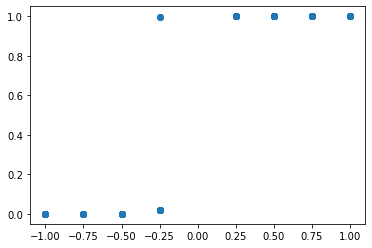

In [8]:
plt.scatter(session_data['delta_contrast'][train_trials], utils.sigmoid(stim@AE))

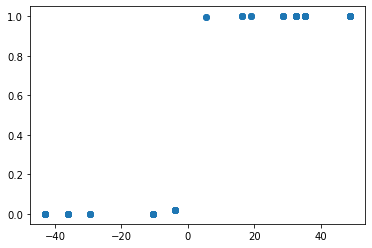

In [20]:
plt.scatter(stim@AE, utils.sigmoid(stim@AE))